In [1]:
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import rasterio
import tqdm
from matplotlib import pyplot as plt
from rasterio.plot import show

In [2]:
files = list(Path("/Users/kyledorman/data/kelp").glob("*/labels/*.tif"))
len(files)

409

In [3]:
df = pd.DataFrame(
    [
        {
            "path": f,
            "acquired": datetime.datetime.strptime(f.stem.split("_")[0], "%Y%m%d"),
            "year": datetime.datetime.strptime(f.stem.split("_")[0], "%Y%m%d").year,
            "region": f.stem.split("_")[-1],
        }
        for f in files
        if "_waves_" not in f.stem
    ]
)

df.head(5)

,path,acquired,year,region
0,/Users/kyledorman/data/kelp/test/labels/202012...,2020-12-21,2020,monterey
1,/Users/kyledorman/data/kelp/test/labels/202109...,2021-09-22,2021,santaBarbara
2,/Users/kyledorman/data/kelp/test/labels/202103...,2021-03-29,2021,santaBarbara
3,/Users/kyledorman/data/kelp/test/labels/202104...,2021-04-08,2021,islaNavidad
4,/Users/kyledorman/data/kelp/test/labels/202104...,2021-04-13,2021,northernCalifornia


In [4]:
counts = df.sort_values(by=["region", "year"]).groupby(["region", "year"]).size()
counts

region              year
bigSur              2020    15
                    2021    31
                    2022    19
britishColumbia     2020     2
                    2021     6
                    2022     6
channelIslands      2020     1
                    2021     9
                    2022    11
islaNavidad         2020     6
                    2021    16
monterey            2020     2
                    2022    12
northernCalifornia  2020     5
                    2021    28
palosVerdes         2020     1
                    2021    13
                    2022    15
puntaEugenia        2020     4
                    2021    31
                    2022    24
sanDiego            2021    10
                    2022     7
santaBarbara        2020     3
                    2021    33
dtype: int64

In [5]:
region_mask = df.region == "britishColumbia"
year_mask = df.year == 2022
paths = df[region_mask & year_mask]
paths.path

8      /Users/kyledorman/data/kelp/test/labels/202204...
74     /Users/kyledorman/data/kelp/train/labels/20220...
102    /Users/kyledorman/data/kelp/train/labels/20220...
148    /Users/kyledorman/data/kelp/train/labels/20220...
241    /Users/kyledorman/data/kelp/train/labels/20220...
295    /Users/kyledorman/data/kelp/val/labels/2022041...
Name: path, dtype: object

In [6]:
with rasterio.open(files[0]) as src:
    print(src.transform)
    print((abs(src.transform.a) * abs(src.transform.e)) ** 0.5)

| 3.00, 0.00, 588717.00|
| 0.00,-3.00, 4050339.00|
| 0.00, 0.00, 1.00|
3.0


In [28]:
import math

from rasterio.enums import Resampling
from rasterio.transform import from_origin
from rasterio.warp import reproject, transform_bounds


def union_bounds_in_ref_crs(ref_crs, src_paths: list[Path]) -> tuple[float, float, float, float]:
    """
    Compute union bounds in reference dataset CRS.
    """
    with rasterio.open(src_paths[0]) as src:
        minx, miny, maxx, maxy = src.bounds
    for p in src_paths[1:]:
        with rasterio.open(p) as ds:
            b = ds.bounds
            b_in_ref = transform_bounds(ds.crs, ref_crs, *b, densify_pts=21)
            minx = min(minx, b_in_ref[0])
            miny = min(miny, b_in_ref[1])
            maxx = max(maxx, b_in_ref[2])
            maxy = max(maxy, b_in_ref[3])
    return (minx, miny, maxx, maxy)


def derive_grid(ref_transform, union_bounds) -> tuple[rasterio.Affine, int, int]:
    """
    Use ref_ds pixel size and union bounds to build an output grid.
    Align to pixel grid of the reference (upper-left alignment).
    """
    xres = ref_transform.a
    yres = ref_transform.e  # negative for north-up
    if not (xres > 0 and yres < 0):
        raise ValueError("Unexpected transform (expect north-up with negative yres).")

    minx, miny, maxx, maxy = union_bounds

    # Align union bounds to reference pixel grid
    # Snap upper-left to integer pixel multiple
    ref_origin_x = ref_transform.c
    ref_origin_y = ref_transform.f

    # column/row of the union's upper-left in ref grid
    col_ul = math.floor((minx - ref_origin_x) / xres)
    row_ul = math.floor((ref_origin_y - maxy) / (-yres))

    # column/row of the union's lower-right in ref grid (exclusive)
    col_lr = math.ceil((maxx - ref_origin_x) / xres)
    row_lr = math.ceil((ref_origin_y - miny) / (-yres))

    width = col_lr - col_ul
    height = row_lr - row_ul

    out_ul_x = ref_origin_x + col_ul * xres
    out_ul_y = ref_origin_y + row_ul * yres

    out_transform = from_origin(out_ul_x, out_ul_y, xres, -yres)
    return out_transform, height, width


def reproject_to_grid(
    src_path: Path, dst_arr: np.ndarray, dst_transform, dst_crs, dst_nodata: int = 0
):
    """
    Reproject a single-band uint8 label raster into dst_arr (same shape), nearest neighbor.
    """
    with rasterio.open(src_path) as src:
        src_arr = src.read(1)
        reproject(
            source=src_arr,
            destination=dst_arr,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest,
            src_nodata=0,
            dst_nodata=0,
        )


def merge_tifs(paths):
    crses = {}
    for p in paths:
        with rasterio.open(p) as src:
            cc = str(src.crs)
            if cc not in crses:
                crses[cc] = 0
            crses[cc] += 1
    ref_crs = sorted([(v, k) for k, v in crses.items()], reverse=True)[0][1]
    for p in paths:
        with rasterio.open(p) as src:
            if str(src.crs) == ref_crs:
                ref_transform = src.meta["transform"]

    union_bounds = union_bounds_in_ref_crs(ref_crs, paths)
    out_transform, out_h, out_w = derive_grid(ref_transform, union_bounds)

    count_target = np.zeros((out_h, out_w), dtype=np.uint8)
    count_valid = np.zeros((out_h, out_w), dtype=np.uint8)

    # Reproject one by one into a temporary uint8 buffer, then update counts
    tmp = np.zeros((out_h, out_w), dtype=np.uint8)
    for i, p in enumerate(tqdm.tqdm(paths), 1):
        tmp.fill(0)
        reproject_to_grid(p, tmp, out_transform, ref_crs, dst_nodata=0)
        # valid = label != 0 (i.e., not nodata)
        valid_mask = tmp != 3
        # target = label == target_label
        target_mask = tmp == 1

        count_valid[valid_mask] += 1
        count_target[target_mask] += 1

    return count_target, count_valid, out_transform, union_bounds, ref_crs


count_target, count_valid, out_transform, bounds, ref_crs = merge_tifs(paths.path.tolist())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 101.31it/s]


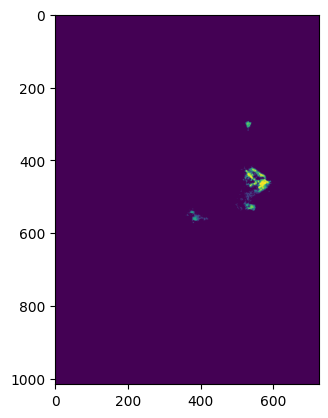

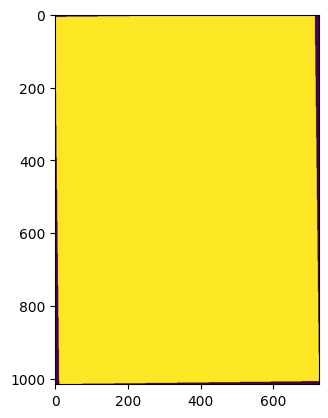

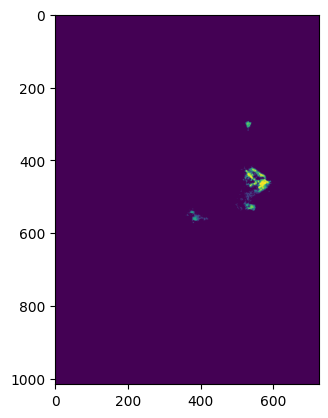

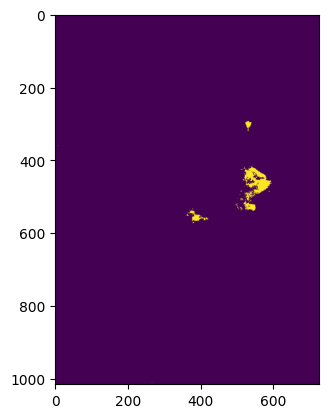

<Axes: >

In [29]:
plt.figure()
show(count_target, plt.gca())

plt.figure()
show(count_valid, plt.gca())

plt.figure()
show(count_target / np.maximum(1, count_valid), plt.gca())

plt.figure()
show(count_target / np.maximum(1, count_valid) > 0, plt.gca())

In [33]:
from pyproj import Transformer


def convert_to_wgs(bounds, src_crs):
    src_crs = ref_crs

    # Build a transformer to WGS84 (lon/lat)
    to_wgs84 = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)

    # Transform all four corners; Earth Engine expects lon/lat
    ll_lon, ll_lat = to_wgs84.transform(minx, miny)
    lr_lon, lr_lat = to_wgs84.transform(maxx, miny)
    ul_lon, ul_lat = to_wgs84.transform(minx, maxy)
    ur_lon, ur_lat = to_wgs84.transform(maxx, maxy)

    # Get bbox in lon/lat (min/max across transformed corners)
    min_lon = min(ll_lon, lr_lon, ul_lon, ur_lon)
    max_lon = max(ll_lon, lr_lon, ul_lon, ur_lon)
    min_lat = min(ll_lat, lr_lat, ul_lat, ur_lat)
    max_lat = max(ll_lat, lr_lat, ul_lat, ur_lat)

    return min_lon, min_lat, max_lon, max_lat

In [31]:
def snap_bbox_to_grid_utm(xmin, ymin, xmax, ymax, pixel_size=10.0):
    # snap to 10 m grid (upper-left origin style)
    xmin_s = math.floor(xmin / pixel_size) * pixel_size
    ymin_s = math.floor(ymin / pixel_size) * pixel_size
    xmax_s = math.ceil(xmax / pixel_size) * pixel_size
    ymax_s = math.ceil(ymax / pixel_size) * pixel_size
    return xmin_s, ymin_s, xmax_s, ymax_s


print(bounds, snap_bbox_to_grid_utm(*bounds))

(557517.0, 5721009.0, 559692.0, 5724057.0) (557510.0, 5721000.0, 559700.0, 5724060.0)


In [37]:
import ee

year = 2022
project = "coastal-base"

utm_bounds = snap_bbox_to_grid_utm(*bounds)
wgs_bounds = convert_to_wgs(utm_bounds, ref_crs)

# Initialize the Earth Engine API
ee.Initialize(project=project)

# Load the embedding dataset (annual)
dataset = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")

# Pick a year
roi = ee.Geometry.BBox(*wgs_bounds)
img = dataset.filterDate(f"{year}-01-01", f"{year + 1}-01-01").filterBounds(roi).first()

drive_folder: str = "GEE_exports"
file_prefix: str = "embedding"

# 3) Export to Google Drive at native 10 m resolution, using the chosen UTM CRS
task = ee.batch.Export.image.toDrive(
    image=img,
    description=f"{file_prefix}_{year}",
    folder=drive_folder,
    fileNamePrefix=f"{file_prefix}_{year}",
    region=roi,  # EE geometry in WGS84
    scale=10,  # native 10 m
    crs=ref_crs,  # eg "EPSG:32610" based on TIFF center
    maxPixels=1_000_000_000,  # bump if needed (within EE limits)
)
task.start()

# rjson = json.dumps(roi.getInfo())
# print("Getting download url")

# # Request a download URL (GeoTIFF)
# url = img.getDownloadURL({
#     "scale": 10,
#     "crs": ref_crs,   # align with local UTM
#     "region": rjson,
#     "format": "GEO_TIFF"
# })
# print("Download URL:", url)

# # Stream and save to disk
# out_path = Path("/Users/kyledorman/Desktop/test_embeddings.tif")
# with requests.get(url, stream=True) as r:
#     r.raise_for_status()
#     with open(out_path, "wb") as f:
#         for chunk in r.iter_content(chunk_size=8192):
#             f.write(chunk)

# print(f"Saved to {out_path.resolve()}")

In [77]:
emb_pth = Path("/Users/kyledorman/Downloads/embedding_2022.tif")
with rasterio.open(emb_pth) as src:
    print(src.meta)
    emb = src.read()

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 225, 'height': 311, 'count': 64, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 9N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32609"]]'), 'transform': Affine(10.0, 0.0, 557480.0,
       0.0, -10.0, 5724090.0)}


In [59]:
def _area_from_transform(transform: rasterio.Affine) -> float:
    # For north-up affine, pixel area ≈ |a| * |e|
    return abs(transform.a) * abs(transform.e)


# Open target reference grid (10m embedding grid)
with rasterio.open(emb_pth) as ref:
    dst_crs = ref.crs
    dst_transform = ref.transform
    dst_h, dst_w = ref.height, ref.width
    dst_area = _area_from_transform(dst_transform)

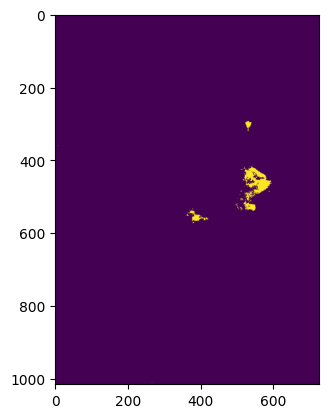

<Axes: >

In [66]:
plt.figure()
show(count_target > 0, plt.gca())

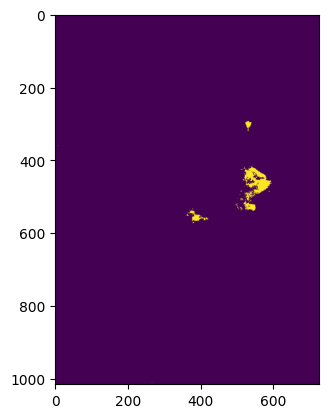

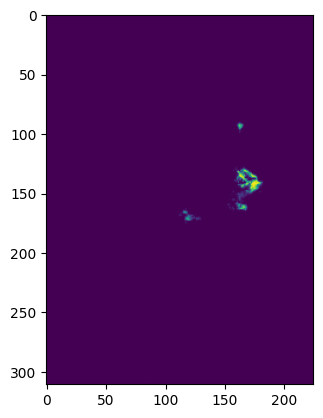

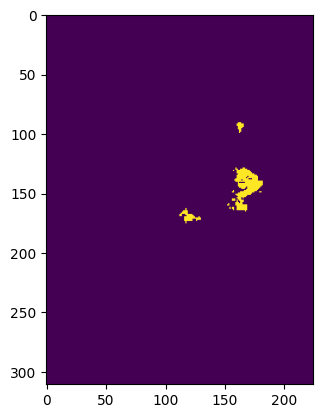

<Axes: >

In [76]:
# Prepare output arrays
majority = np.zeros((dst_h, dst_w), dtype=np.uint8)
frac_target = np.zeros((dst_h, dst_w), dtype=np.float32)
frac_valid = np.zeros((dst_h, dst_w), dtype=np.float32)  # to derive counts

src_arr = count_target
src_arr[count_valid == 0] = 0

reproject(
    source=src_arr,
    destination=majority,
    src_transform=out_transform,
    src_crs=ref_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.sum,
    src_nodata=0,
    dst_nodata=0,
)

plt.figure()
show(count_target > 0, plt.gca())

plt.figure()
show(majority, plt.gca())

plt.figure()
show(majority > 1, plt.gca())

In [90]:
label = np.uint8(majority > 1)
emb.reshape(64, -1).shape

(64, 69975)

In [91]:
label.flatten().shape

(69975,)

In [134]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

X_train = emb.reshape(64, -1).T
y_train = label.flatten()
clf = svm.SVC(random_state=42, class_weight="balanced")
clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict classes on test set
svn_pred = clf.predict(X_train)

In [135]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_train, svn_pred)

1.0

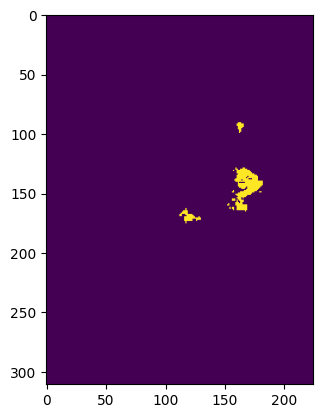

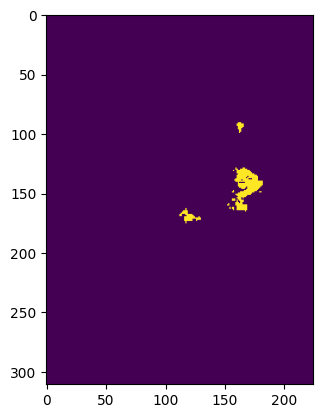

<Axes: >

In [136]:
plt.figure()
show(svn_pred.reshape(label.shape), plt.gca())

plt.figure()
show(label, plt.gca())

Top 10 most important channels:
Channel 23: weight=6.5095
Channel 17: weight=-6.4554
Channel 7: weight=5.0473
Channel 8: weight=4.7833
Channel 25: weight=-3.4062
Channel 63: weight=3.2969
Channel 24: weight=3.0153
Channel 59: weight=2.9558
Channel 14: weight=2.8661
Channel 19: weight=-2.6759


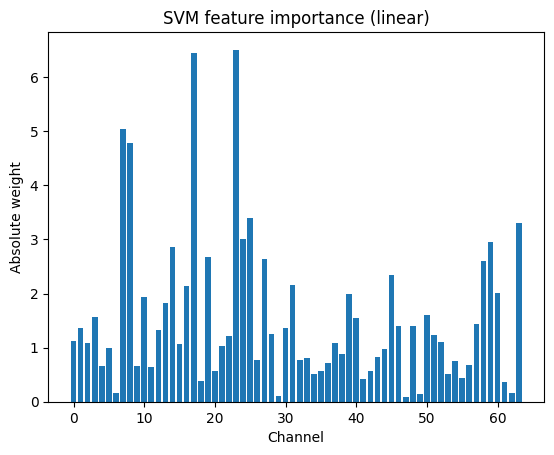

In [104]:
# clf is a fitted sklearn.svm.SVC(kernel="linear") or LinearSVC
coefs = clf.coef_.ravel()  # shape (n_channels,)

# Rank channels by absolute weight
ranking = np.argsort(np.abs(coefs))[::-1]

print("Top 10 most important channels:")
for idx in ranking[:10]:
    print(f"Channel {idx}: weight={coefs[idx]:.4f}")

# Quick bar plot
plt.bar(range(len(coefs)), np.abs(coefs))
plt.xlabel("Channel")
plt.ylabel("Absolute weight")
plt.title("SVM feature importance (linear)")
plt.show()

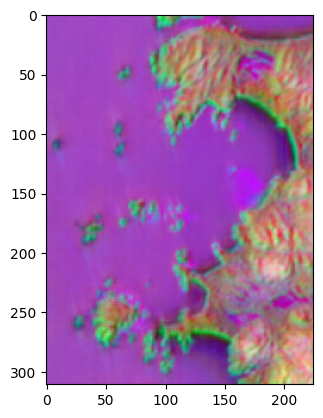

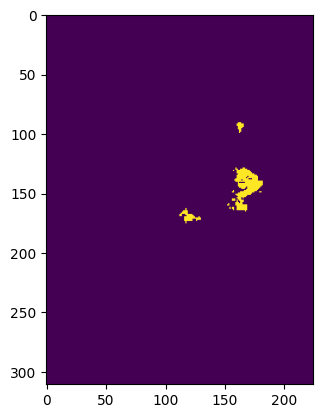

<Axes: >

In [112]:
img = emb[[8, 17, 23]]
for i in range(3):
    img[i] = img[i] - img[i].min()
    img[i] = img[i] / img[i].max()
plt.figure()
show(img)
plt.figure()
show(label)

In [124]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from rasterio.enums import Resampling
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler


def percent_clip01(x, low=2.0, high=98.0):
    lo = np.percentile(x, low)
    hi = np.percentile(x, high)
    x = np.clip((x - lo) / max(1e-6, (hi - lo)), 0, 1)
    return x


def pca_rgb(X, valid, H, W):
    # Standardize per-channel (fit on valid only, transform all)
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = np.zeros_like(X, dtype=np.float32)
    Xs[valid] = scaler.fit_transform(X[valid])
    Xs[~valid] = 0.0

    pca = PCA(n_components=3, svd_solver="randomized", random_state=42)
    PCs = np.zeros((X.shape[0], 3), dtype=np.float32)
    PCs[valid] = pca.fit_transform(Xs[valid])

    # Normalize each PC channel to 0..1 with robust clipping
    r = percent_clip01(PCs[:, 0])
    g = percent_clip01(PCs[:, 1])
    b = percent_clip01(PCs[:, 2])
    rgb = np.stack([r, g, b], axis=1).reshape(H, W, 3)
    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return rgb_uint8


def tsne_rgb(
    X,
    valid,
    H,
    W,
    subsample=50000,
    perplexity=30,
    learning_rate="auto",
    n_iter=1000,
    random_state=42,
):
    """
    t-SNE on a subset, then KNN-regress the 2D layout to all points.
    Map 2D -> 3-channel RGB via simple normalization + fixed third channel for contrast.
    """
    idx_valid = np.flatnonzero(valid)
    if len(idx_valid) == 0:
        raise ValueError("No valid pixels for t-SNE.")
    n_sub = min(subsample, len(idx_valid))
    rng = np.random.default_rng(random_state)
    idx_sub = rng.choice(idx_valid, size=n_sub, replace=False)

    # Standardize features using only valid pixels (and apply to subset & all)
    scaler = StandardScaler()
    Xs_valid = scaler.fit_transform(X[valid])
    Xs_all = np.zeros_like(X, dtype=np.float32)
    Xs_all[valid] = Xs_valid

    # t-SNE on the subset
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            learning_rate=learning_rate,
            max_iter=n_iter,
            init="pca",
            metric="euclidean",
            random_state=random_state,
            verbose=0,
        )
    Y_sub = tsne.fit_transform(Xs_all[idx_sub])

    # Interpolate to all pixels with KNN regression
    knn = KNeighborsRegressor(n_neighbors=5, weights="distance")
    knn.fit(Xs_all[idx_sub], Y_sub)
    Y_all = np.zeros((X.shape[0], 2), dtype=np.float32)
    Y_all[valid] = knn.predict(Xs_all[valid])

    # Normalize Y to 0..1 and create an RGB
    y0 = percent_clip01(Y_all[:, 0])
    y1 = percent_clip01(Y_all[:, 1])
    # fake a third channel for contrast using radius in t-SNE space
    r2 = Y_all[:, 0] ** 2 + Y_all[:, 1] ** 2
    y2 = percent_clip01(r2)

    rgb = np.stack([y0, y1, y2], axis=1).reshape(H, W, 3)
    rgb_uint8 = (rgb * 255).astype(np.uint8)

    # mask invalid to black
    rgb_uint8[~valid.reshape(H, W)] = 0
    return rgb_uint8


H, W = label.shape
valid = np.ones(H * W, dtype=bool)
pca_img = pca_rgb(X_train, valid, H, W)

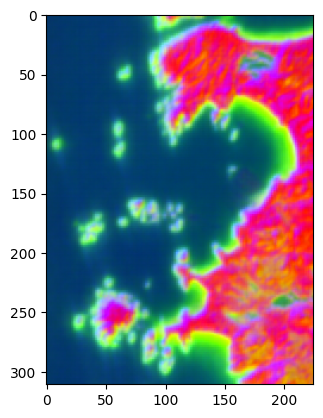

In [125]:
plt.figure()
plt.imshow(pca_img)

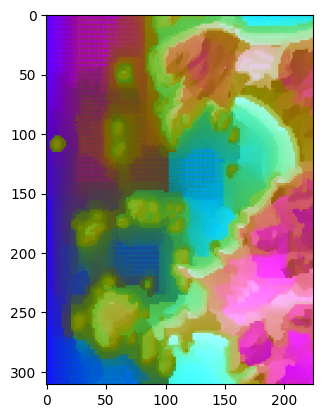

In [126]:
# t-SNE RGB
subsample = 50000
perplexity = 30
learning_rate = "auto"
n_iter = 1000
random_state = 42
tsne_img = tsne_rgb(
    X_train,
    valid,
    H,
    W,
    subsample=subsample,
    perplexity=perplexity,
    n_iter=n_iter,
)

plt.figure()
plt.imshow(tsne_img)